In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib

from id01lib import id01h5
from id01lib.xrd.qconversion import scan_to_qspace_h5,qconvert_mgrid
from id01lib.xrd.geometries import ID01psic
from mpl_toolkits.axes_grid1 import make_axes_locatable
from silx.io import specfile as spec

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
matplotlib.rcParams['font.size'] = 10

%gui qt5

/users/zatterin/Envs/py3/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [147]:
# Sample and scans
fname = '/users/zatterin/Documents/beam/20170712_HC2912/data/hc2912.h5'
sample = 'E16095_furnace'
scan_no = 34

# Experimental parameters
det_distance =  0.422
cen_pix = [281.847,278.792] # x, y
nrj=8
nbins = (100,200,200)
# nbins = (-1,-1,-1)

# Open the h5 file
with h5py.File(fname) as h5f:
    
    # read / set offsets
    scan = h5f['/{0}/{1}.1'.format(sample,scan_no)]
    phi_off = h5f['/{0}/{1}.1/instrument/positioners/phi'.format(sample,scan_no)].value
    rhx_off = h5f['/{0}/{1}.1/instrument/positioners/rhx'.format(sample,scan_no)].value
    rhy_off = h5f['/{0}/{1}.1/instrument/positioners/rhy'.format(sample,scan_no)].value
    nu_off =  h5f['/{0}/{1}.1/instrument/positioners/nu'.format(sample,scan_no)].value
    ID01psic().usemotors = set(('eta', 'phi', 'nu', 'delta'))
    
    # set to corresponding offsets if needed
    ID01psic().set_offsets(eta=0, rhy=0, rhx=0.656, phi=1.994, nu=0)
    
    # convert to q space
    qx, qy, qz, gint = scan_to_qspace_h5(scan, 
                                         cen_pix=(cen_pix[1],cen_pix[0]), 
                                         distance=det_distance, 
                                         energy=8,
                                         nbins=nbins)

Selected /E16095_furnace/34.1
Offsets used: rhz = 0.0, mu = 0.0, rhy = 0.0, rhx = 0.656, eta = 0.0, delta = 0.0, nu = 0.0, phi = 1.994, 
Max. number of bins: 355, 532, 518
Using binning: (200, 200, 200)


In [148]:
qxx, qyy, qzz, i = qconvert_mgrid(qx, qy, qz, gint, 5)


Gridding with bins: (200, 200, 200)


In [149]:
i.min(), i.max()

(1.4840718817214302, 6.48407188172143)

In [188]:
ax.spines

OrderedDict([('left', <matplotlib.spines.Spine at 0x7fce1f747550>),
             ('right', <matplotlib.spines.Spine at 0x7fce1f747cc0>),
             ('bottom', <matplotlib.spines.Spine at 0x7fcdd8359240>),
             ('top', <matplotlib.spines.Spine at 0x7fcdd8359f60>)])

Text(0,0.5,'$\\mathbf{Q_z}$')

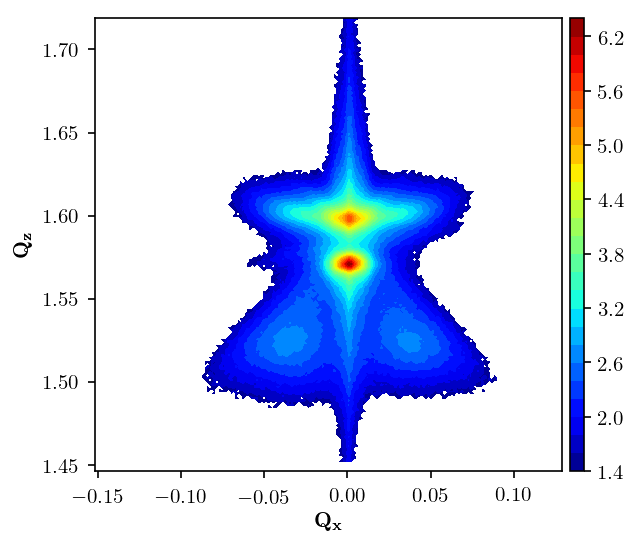

In [179]:
%matplotlib inline
# toplot = np.log(gint.sum(0))
maskedi = np.ma.masked_where(i<=i.min(),i)
toplot = maskedi[107,:,:]

fig = plt.figure(dpi=150, facecolor='white')
ax = plt.gca()
ax.axis('equal')

im = ax.contourf(qyy[0,:,:],qzz[0,:,:],toplot,30,cmap='jet')

divider = make_axes_locatable(ax)
coloraxis = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(im, cax=coloraxis)

ax.set_xlabel(r'$\mathbf{Q_x}$')
ax.set_ylabel(r'$\mathbf{Q_z}$')

Text(0,0.5,'$\\mathbf{Q_z}$')

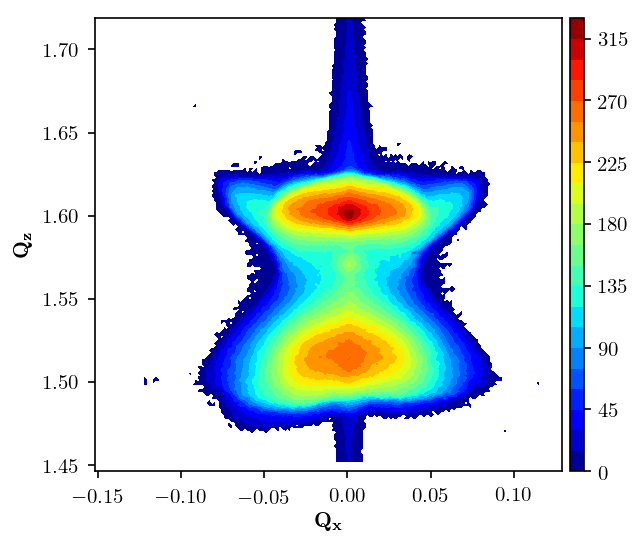

In [157]:
%matplotlib inline
# toplot = np.log(gint.sum(0))
maskedi = np.ma.masked_where(i<=i.min(),i)
toplot = maskedi.sum(0)

fig = plt.figure(dpi=150, facecolor='white')
ax = plt.gca()
ax.axis('equal')

im = plt.contourf(qyy[0,:,:],qzz[0,:,:],toplot,30,cmap='jet')

divider = make_axes_locatable(ax)
coloraxis = divider.append_axes('right', size='3%', pad=0.05)
cbar = plt.colorbar(im, cax=coloraxis)

ax.set_xlabel(r'$\mathbf{Q_x}$')
ax.set_ylabel(r'$\mathbf{Q_z}$')

In [ ]:
@interact